In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import json

C:\Users\Alice Dias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 💾CARREGA E AGRUPA POR DIA

In [2]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# filtra CP 4610, converte e ordena
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# agrega média diária de ActiveEnergy(kWh)
daily = (
    df_cp
    .set_index("DateTime")
    .resample("D")["ActiveEnergy(kWh)"]
    .mean()
    .to_frame("ActiveEnergy")
    .reset_index()
)

#### CRIA LAG DE 7 DIAS (exógena)

In [3]:
daily["lag_7"] = daily["ActiveEnergy"].shift(7)

# descarta primeiras 7 linhas com NaN
daily = daily.dropna().reset_index(drop=True)

# marca sempre o mesmo id ("4610") para montar o TimeSeriesDataFrame
daily["ZipCode"] = "4610"

# extrai static feature
static_feats = df_cp[["ZipCode","PopulationDensity"]].drop_duplicates()

#### MONTA O TimeSeriesDataFrame

In [4]:
ts_df = TimeSeriesDataFrame.from_data_frame(
    daily,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🛠 SPLIT TREINO/TESTE: últimos 7 dias em teste

In [5]:
prediction_length=7
train_daily, test_daily = ts_df.train_test_split(prediction_length=prediction_length)

# Modelos Tradicionais (Baseline)
# 📊ARIMA
#### 💾 (Opcional) Carregar um modelo existente

In [6]:
predictor_arima = TimeSeriesPredictor.load("./predicts/ARIMA_daily/modelo/")

#### 🛠️ Treinar

In [62]:
predictor_arima = TimeSeriesPredictor(
    target="ActiveEnergy",
    freq="D",
    prediction_length=prediction_length,
    path="predicts/ARIMA_daily/modelo",
    verbosity=2
).fit(
    train_data=train_daily,
    tuning_data=test_daily,
    hyperparameters={
        "ARIMAModel": {
            "order": (1, 1, 1),            # (p, d, q)
            "seasonal_order": (1, 0, 1, 7),# (P, D, Q, m)
            "target_scaler": "standard"   # normaliza o target
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True      # força só ARIMA, sem ensembles
)

# Salva o modelo
predictor_arima.save()

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA_daily\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.69 GB / 15.93 GB (23.2%)
Disk Space Avail:   690.66 GB / 931.46 GB (74.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'ARIMAModel': {'order': (1, 1, 1),
                                    'seasonal_order': (1, 0, 1, 7),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 7,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows':

#### 🔮 Previsão com os dados de treino

In [7]:
# faz a previsão dos próximos 7 dias
future_preds = predictor_arima.predict(train_daily)

# extrai o quantil 0.5 e “desempacota” o índice de item_id
y_pred = future_preds["0.5"].droplevel(0)
y_true_full = test_daily["ActiveEnergy"].droplevel(0)

# extrai só os 7 valores reais que estão em test_daily
y_true = y_true_full.iloc[-7:]

y_true.shape: (7,)
y_pred.shape: (7,)


#### 📊  Avaliação do modelo

In [8]:
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2   = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"R²:   {r2:.5f}")

MAE:  290.85553
MSE:  122719.42992
RMSE: 350.31333
MAPE: 3.22017%
R²:   0.96791


### 📊 **Métricas de Avaliação**

| Métrica                                     | Valor | Interpretação |
|---------------------------------------------|-------|---------------|
| **MAE** (Erro Absoluto Médio)               | 290.85553 | Em média, as previsões diferem dos valores reais em cerca de 290,86 kWh. |
| **MSE** (Erro Quadrático Médio)             | 122719.42992   | Erro médio ao quadrado, penaliza fortemente grandes desvios. |
| **RMSE** (Raiz do Erro Quadrático Médio)    | 350.31333 | Desvio típico das previsões em relação ao real é de aproximadamente 350,31 kWh. |
| **MAPE** (Erro Percentual Absoluto Médio)   | 3.22% | Em média, as previsões estão 3,22 % distantes dos valores reais. |
| **R²**   | 0.96791 | O modelo explica 96,79 % da variância observada nos dados — indicativo de um bom ajuste. |

#### 📈 Visualização dos resultados

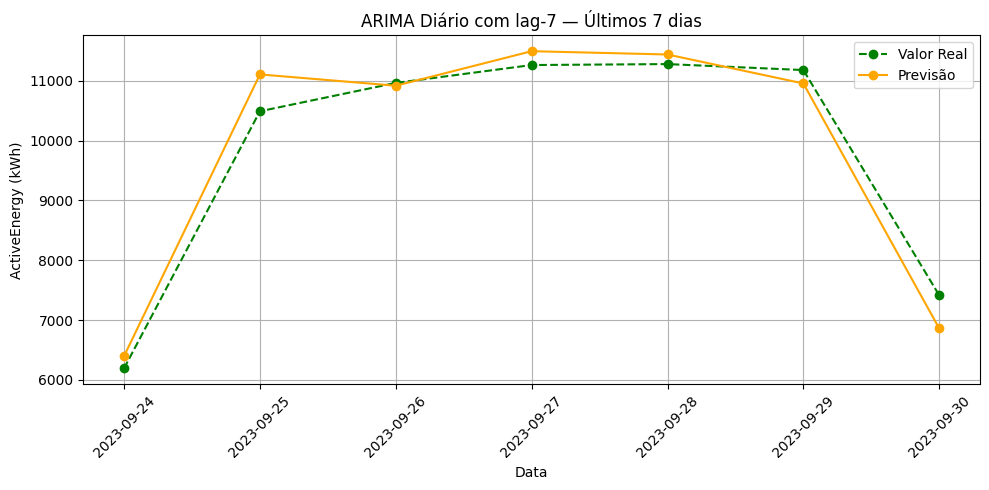

In [9]:
# valor real vs previsão
plt.figure(figsize=(10,5))
plt.plot(y_true.index, y_true.values, marker='o', linestyle='--',  label='Valor Real',  color='green')
plt.plot(y_pred.index, y_pred.values, marker='o', label='Previsão',  color='orange')
plt.title("ARIMA Diário com lag-7 — Últimos 7 dias")
plt.xlabel("Data")
plt.ylabel("ActiveEnergy (kWh)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figuras/arima_daily_forecast.png", dpi=300)
plt.show()